In [20]:
# step 1 : Load Data

from keras.datasets import boston_housing

(train_data,train_target),(test_data,test_target) = boston_housing.load_data()

In [21]:
# step 2 : Data Preprocessing (Normalization)

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data-mean)/std
test_data = (test_data-mean)/std 
# 注意：测试集数据因为是会随时改变的，所以一定是用训练集的均值和标准差进行正则化

In [28]:
# step 3 : construct the model

from keras import models
from keras import layers

# 因为后面要使用“K折验证法”，需要多次实例化同一个模型，所以这里使用函数进行定义
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [39]:
# step 4 : fit the model （K折交叉验证）
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_score = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_target = train_target[i*num_val_samples : (i+1)*num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[0:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_target = np.concatenate(
        [train_target[0:i*num_val_samples],
        train_target[(i+1)*num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data,partial_train_target,batch_size=1,epochs=num_epochs,verbose=0,validation_data=(val_data,val_target))
    val_mse,val_mae = model.evaluate(val_data,val_target,verbose=0)
    val_mae_history = history.history['val_mae']
    all_score.append(val_mae_history)
    #print(history.history.keys())

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


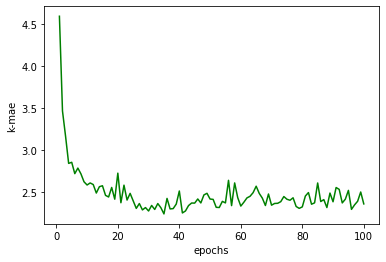

In [41]:
# step 5 : plot the model
np.asarray(all_score).shape
kavrg_mae_score = np.mean(np.asarray(all_score),axis=0)
epochs = range(1,len(kavrg_mae_score)+1)

import matplotlib.pyplot as plt

plt.plot(epochs,kavrg_mae_score,'g')
plt.xlabel('epochs')
plt.ylabel('k-mae')
plt.show()

In [43]:
# step 6 : prediction and/or evaluation

# 前面的第4，5步的K折验证只是为了在数据量较少的情况下，更合理的评估模型，看模型的超参数取什么更合适。
# 由图可知，大约在epochs等于35时比较合适。所以重新构建一个模型，令超参数取更合适的值以避免过拟合

model = build_model()
model.fit(train_data,train_target,batch_size=16,epochs=80,verbose=0)
test_mse_score,test_mae_score = model.evaluate(test_data,test_target)

test_mae_score


102/102 [==============================] - 0s 127us/step


2.789566993713379